# Credit Risk Model Building

* Using the exported CSV file from EDA in our model building process

# Tools & Libraries Used

- Python
- Pandas
- Numpy
- Matplotlib
- Seaborn
- Sklearn
- Jupyter Notebook

## 1. Import Libraries & Load Data

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('C:\\Users\\Win10\\Documents\\Python Code\\Customer Risk Prediction\\Customer360Clean.csv')

## 2. Quick Check Before Model Building

### Leakage Check

Before building the model, it is important to make sure we are not using any future information that would not be available at the time of prediction (data leakage).  

In this dataset:  
- Features are created as 12-month aggregates (e.g., average income, total overdue days, spending patterns).  
- Target variables are flags for **default** and **churn**.  

This setup is acceptable for a portfolio demo project.  

However, in a real-world scenario we should:  
- Use customer data available up to time **T**.  
- Predict whether the customer will default or churn in **T+1** (the following period).  

This ensures the model only uses information that would realistically be available at prediction time.  

In [3]:
df.head()

,CUSTOMER_ID,AGE,GENDER,INCOME_BRACKET,EMPLOYMENT_STATUS,CITY,CREDIT_SCORE,LOAN_HISTORY,CREDIT_UTILIZATION,SAVINGS_ACCOUNT,...,AVG_MONTHLY_INCOME,AVG_MONTHLY_EXPENSE,AVG_RETAIL_SPEND,AVG_TRAVEL_SPEND,AVG_BILLS_SPEND,DELINQUENCY_COUNT_12M,TOTAL_OVERDUE_DAYS_12M,OVER_BUDGET_RATIO,DEFAULT_FLAG,CREDITSCORE_BAND
0,CUST0001,59,Female,3-6 LPA,Salaried,Ahmedabad,562,No Loans,10.11,1,...,32002.633333,23262.615000,8640.141667,3700.469167,10922.001667,2,10,0.0,1,<580
1,CUST0002,49,Other,15-25 LPA,Salaried,Ahmedabad,656,3-5 Loans,33.48,1,...,198365.212500,138507.950000,51624.084167,20119.741667,66764.126667,1,30,0.0,0,650-700
2,CUST0003,35,Female,3-6 LPA,Self-Employed,Bengaluru,560,3-5 Loans,33.73,1,...,49154.954167,38447.845000,14018.418333,4676.601667,19600.621667,5,140,0.0,0,<580
3,CUST0004,63,Female,<3 LPA,Unemployed,Kolkata,664,1-2 Loans,38.47,1,...,8074.589167,5941.880833,2074.025000,1116.963333,2750.894167,1,30,0.0,0,650-700
4,CUST0005,28,Female,3-6 LPA,Self-Employed,Hyderabad,748,1-2 Loans,37.43,1,...,41412.081667,29206.231667,12136.246667,4498.485000,12571.502500,0,0,0.0,0,700-750


In [4]:
df.columns

Index(['CUSTOMER_ID', 'AGE', 'GENDER', 'INCOME_BRACKET', 'EMPLOYMENT_STATUS',
       'CITY', 'CREDIT_SCORE', 'LOAN_HISTORY', 'CREDIT_UTILIZATION',
       'SAVINGS_ACCOUNT', 'CREDIT_CARD', 'LOAN_TYPE', 'LOAN_AMOUNT',
       'INSURANCE', 'FD_INVESTMENT', 'NET_BANKING_USAGE', 'MOBILE_APP_USAGE',
       'COMPLAINTS_RAISED', 'RESPONSE_TO_OFFERS', 'CHURN_FLAG',
       'AVG_MONTHLY_INCOME', 'AVG_MONTHLY_EXPENSE', 'AVG_RETAIL_SPEND',
       'AVG_TRAVEL_SPEND', 'AVG_BILLS_SPEND', 'DELINQUENCY_COUNT_12M',
       'TOTAL_OVERDUE_DAYS_12M', 'OVER_BUDGET_RATIO', 'DEFAULT_FLAG',
       'CREDITSCORE_BAND'],
      dtype='object')

In [5]:
df.isna().sum()

CUSTOMER_ID                 0
AGE                         0
GENDER                      0
INCOME_BRACKET              0
EMPLOYMENT_STATUS           0
CITY                        0
CREDIT_SCORE                0
LOAN_HISTORY                0
CREDIT_UTILIZATION          0
SAVINGS_ACCOUNT             0
CREDIT_CARD                 0
LOAN_TYPE                 514
LOAN_AMOUNT                 0
INSURANCE                   0
FD_INVESTMENT               0
NET_BANKING_USAGE           0
MOBILE_APP_USAGE            0
COMPLAINTS_RAISED           0
RESPONSE_TO_OFFERS          0
CHURN_FLAG                  0
AVG_MONTHLY_INCOME          0
AVG_MONTHLY_EXPENSE         0
AVG_RETAIL_SPEND            0
AVG_TRAVEL_SPEND            0
AVG_BILLS_SPEND             0
DELINQUENCY_COUNT_12M       0
TOTAL_OVERDUE_DAYS_12M      0
OVER_BUDGET_RATIO           0
DEFAULT_FLAG                0
CREDITSCORE_BAND            0
dtype: int64

In [6]:
# Filling null values in loan type with 'No Loan'

df['LOAN_TYPE'] = df['LOAN_TYPE'].fillna('No Loan')

In [7]:
# Checking for class imbalance

df['DEFAULT_FLAG'].value_counts(normalize=True)*100

DEFAULT_FLAG
0    85.8
1    14.2
Name: proportion, dtype: float64

In [8]:
df['CHURN_FLAG'].value_counts(normalize=True)*100

CHURN_FLAG
0    83.8
1    16.2
Name: proportion, dtype: float64

### Insights:
* There is an imbalance which is not extreme. In credit-risk or churn datasets, 10-20% positive cases is open.
* If we train the model without adjustments, the model might just predict the majority class which are non-default or non-churn too often.
* To balance this, we will use `class_weight=balanced` while using logistic regression or tree models so that the algorithm pays more attention towards minority classes.

In [9]:
df['INCOME_BRACKET'].unique()

array(['3-6 LPA', '15-25 LPA', '<3 LPA', '25+ LPA', '6-10 LPA',
       '10-15 LPA'], dtype=object)

In [10]:
df['LOAN_HISTORY'].unique()

array(['No Loans', '3-5 Loans', '1-2 Loans', '6+ Loans'], dtype=object)

### Insights:
* Nominal categories can be safely handled with One-Hot Encoding (dummy variables).
* Ordinal categories have a natural order so if we simple encode these then the model won't understand the natural order. That means we will lose valuable information.
* So, we will map these ranges into ordered numeric values through ordinal encoding.

### 3. Ordinal Encoding

In [11]:
# Income bracket mapping (approximate midpoint in INR LPA)

income_map = {'<3 LPA': 1.5, '3-6 LPA': 4.5, '6-10 LPA': 8, '10-15 LPA': 12.5, '15-25 LPA': 20, '25+ LPA': 30}
df['INCOME_BRACKET_NUM'] = df['INCOME_BRACKET'].map(income_map)

In [12]:
loan_history_map = {'No Loans': 0, '1-2 Loans': 1.5, '3-5 Loans': 4, '6+ Loans': 6}
df['LOAN_HISTORY_NUM'] = df['LOAN_HISTORY'].map(loan_history_map)

### 4. Feature Engineering

* As we have had observed in our correlation matrix, `AVG_MONTHLY_INCOME` & `AVG_MONTHLY_EXPENSE` are highly correlated to each other, we will engineer a new feature of Expense to Income Ratio so that there is no collineariy and the relationship between expense and income (which can be addressed as financial stres) can be captured here.
* So, we will keep `AVG_MONTHLY_INCOME` & Expense to Income Ratio so that former feature captures earning capacity and latter captures spending pressure.
* In this way, the model know which customer earns how much and whether they overspend relative to income.
* `AVG_RETAIL_SPEND`, `AVG_TRAVEL_SPEND` & `AVG_BILLS_SPEND`are highly correlated so keeping all three of them will almost add same information multiple times.
* This might result in the risk of overfitting.
* So, we will create a combined feature of `TOTAL_CARD_SPEND` which would be a sum of three variables. This will reduce the multicollinearity by combining three highly correlated features into 1.
* It will capture the overall spending behaviour which might be more predictive than any single category.
* The only problem is we won't be able to interpret what kind of spending would be riskier.
* For logistic regression, we will go ahead with `TOTAL_CARD_SPEND` so that it avoids collinearity and keeps it predictiveness.
* Later, when testing with tree based models, we can add back the 3 separate features since tree models handle correlation better.
* We will also remove the column of `TOTAL_OVERDUE_DAYS_12M` due to high collinearity with `DELINQUENCY_COUNT_12M`.

In [13]:
# Feature engineering

spend_columns = ['AVG_RETAIL_SPEND', 'AVG_TRAVEL_SPEND', 'AVG_BILLS_SPEND']
df['TOTAL_CARD_SPEND'] = df[spend_columns].sum(axis=1)

In [14]:
x = df['AVG_MONTHLY_INCOME'].replace({0: np.nan})
df['EXPENSE_TO_INCOME_RATIO'] = (df['AVG_MONTHLY_EXPENSE']/x).clip(upper=5).fillna(0)
# By adding clipping, we are trying to reduce the impact of extreme outliers on the model

In [15]:
df1 = df.copy()

In [16]:
# Dropping redundant, collinear and other features

drop_columns = ['CUSTOMER_ID', 'CREDITSCORE_BAND', 'AVG_MONTHLY_EXPENSE', 'AVG_RETAIL_SPEND', 'AVG_TRAVEL_SPEND',
               'AVG_BILLS_SPEND', 'TOTAL_OVERDUE_DAYS_12M', 'INCOME_BRACKET', 'LOAN_HISTORY']

drop_columns = [x for x in drop_columns if x in df.columns]
df = df.drop(columns=drop_columns)

In [17]:
# Final predictor list

predictors = ['AGE', 'GENDER', 'EMPLOYMENT_STATUS', 'CITY', 'CREDIT_SCORE', 'CREDIT_UTILIZATION', 'LOAN_TYPE', 'LOAN_AMOUNT', 'FD_INVESTMENT', 'INSURANCE',
              'CREDIT_CARD', 'NET_BANKING_USAGE', 'MOBILE_APP_USAGE', 'COMPLAINTS_RAISED', 'RESPONSE_TO_OFFERS', 'AVG_MONTHLY_INCOME',
             'EXPENSE_TO_INCOME_RATIO', 'TOTAL_CARD_SPEND', 'OVER_BUDGET_RATIO', 'DELINQUENCY_COUNT_12M', 'INCOME_BRACKET_NUM', 'LOAN_HISTORY_NUM']

In [18]:
# Categorical splits

nominal_category = ['LOAN_TYPE', 'GENDER', 'EMPLOYMENT_STATUS', 'CITY', 'RESPONSE_TO_OFFERS']
numeric_features = [x for x in predictors if x not in nominal_category]

In [20]:
# Preprocessing

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nominal_category),
        ('num', StandardScaler(), numeric_features),
    ],
    remainder='drop')

In [21]:
target_columns = ['DEFAULT_FLAG', 'CHURN_FLAG']

In [22]:
# Default model

X_default = df[predictors].copy()
y_default = df["DEFAULT_FLAG"].astype(int) 

In [23]:
Xtrain_default, Xtest_default, ytrain_default, ytest_default = train_test_split(
    X_default, y_default, test_size=0.2, random_state=42, stratify=y_default
)

In [24]:
print("DEFAULT y shape:", ytrain_default.shape, ytest_default.shape)
assert ytrain_default.ndim == 1 and ytest_default.ndim == 1

DEFAULT y shape: (800,) (200,)


In [25]:
logreg_default = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=None))
])

In [33]:
# Fit
logreg_default.fit(Xtrain_default, ytrain_default)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['LOAN_TYPE', 'GENDER',
                                                   'EMPLOYMENT_STATUS', 'CITY',
                                                   'RESPONSE_TO_OFFERS']),
                                                 ('num', StandardScaler(),
                                                  ['AGE', 'CREDIT_SCORE',
                                                   'CREDIT_UTILIZATION',
                                                   'LOAN_AMOUNT',
                                                   'FD_INVESTMENT', 'INSURANCE',
                                                   'CREDIT_CARD',
                                                   'NET_BANKING_USAGE',
                                                   'MOBILE_APP_USAGE',
                                                   'COMPLAINTS_RAISED',
                                                   'AVG_MONTHLY_INCOME',
                                                   'EXPENSE_TO_INCOME_RATIO',
                                                   'TOTAL_CARD_SPEND',
                                                   'OVER_BUDGET_RATIO',
                                                   'DELINQUENCY_COUNT_12M',
                                                   'INCOME_BRACKET_NUM',
                                                   'LOAN_HISTORY_NUM'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

In [34]:
# Churn model

X_churn = df[predictors].copy()
y_churn = df["CHURN_FLAG"].astype(int) 

In [35]:
Xtrain_churn, Xtest_churn, ytrain_churn, ytest_churn = train_test_split(
    X_churn, y_churn, test_size=0.2, random_state=42, stratify=y_churn
)

In [36]:
print("CHURN y shape:", ytrain_churn.shape, ytest_churn.shape)
assert ytrain_churn.ndim == 1 and ytest_churn.ndim == 1

CHURN y shape: (800,) (200,)


In [37]:
logreg_churn = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=None))
])

In [38]:
logreg_churn.fit(Xtrain_churn, ytrain_churn)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['LOAN_TYPE', 'GENDER',
                                                   'EMPLOYMENT_STATUS', 'CITY',
                                                   'RESPONSE_TO_OFFERS']),
                                                 ('num', StandardScaler(),
                                                  ['AGE', 'CREDIT_SCORE',
                                                   'CREDIT_UTILIZATION',
                                                   'LOAN_AMOUNT',
                                                   'FD_INVESTMENT', 'INSURANCE',
                                                   'CREDIT_CARD',
                                                   'NET_BANKING_USAGE',
                                                   'MOBILE_APP_USAGE',
                                                   'COMPLAINTS_RAISED',
                                                   'AVG_MONTHLY_INCOME',
                                                   'EXPENSE_TO_INCOME_RATIO',
                                                   'TOTAL_CARD_SPEND',
                                                   'OVER_BUDGET_RATIO',
                                                   'DELINQUENCY_COUNT_12M',
                                                   'INCOME_BRACKET_NUM',
                                                   'LOAN_HISTORY_NUM'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

In [39]:
print(type(ytrain_default), ytrain_default.shape)
print(type(ytrain_churn), ytrain_churn.shape)
print(df[["DEFAULT_FLAG","CHURN_FLAG"]].head())  # verify targets look right


<class 'pandas.core.series.Series'> (800,)
<class 'pandas.core.series.Series'> (800,)
   DEFAULT_FLAG  CHURN_FLAG
0             1           1
1             0           0
2             0           0
3             0           0
4             0           0


In [40]:
# Evaluating the model performance

def evaluate_model(model, Xtrain, ytrain, Xtest, ytest, name="Model"):
    print(f"\n=== {name} Evaluation ===")

    # Predictions
    ytrain_pred = model.predict(Xtrain)
    ytest_pred = model.predict(Xtest)

    # Probabilities (needed for AUC)
    ytrain_proba = model.predict_proba(Xtrain)[:,1]
    ytest_proba = model.predict_proba(Xtest)[:,1]

    # Metrics
    print("Train AUC:", roc_auc_score(ytrain, ytrain_proba).round(3))
    print("Test  AUC:", roc_auc_score(ytest, ytest_proba).round(3))

    print("Test F1 Score:", f1_score(ytest, ytest_pred).round(3))
    print("Test Precision:", precision_score(ytest, ytest_pred).round(3))
    print("Test Recall:", recall_score(ytest, ytest_pred).round(3))

    # Confusion Matrix
    cm = confusion_matrix(ytest, ytest_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plot.title(f"{name} - Confusion Matrix (Test)")
    plot.show()


=== LogReg - Default Evaluation ===
Train AUC: 0.753
Test  AUC: 0.592
Test F1 Score: 0.3
Test Precision: 0.208
Test Recall: 0.536


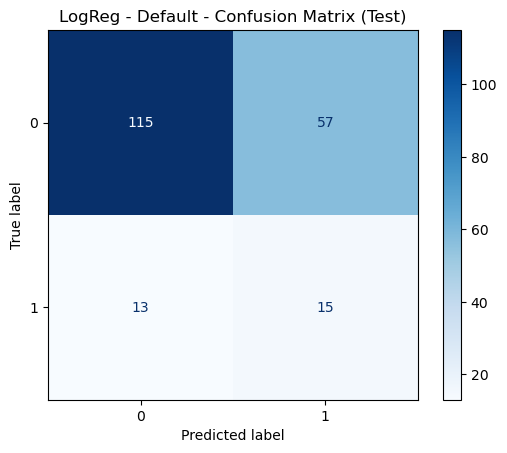

In [41]:
# Evaluating default model

evaluate_model(logreg_default, Xtrain_default, ytrain_default, Xtest_default, ytest_default, name="LogReg - Default")


=== LogReg - Churn Evaluation ===
Train AUC: 0.629
Test  AUC: 0.427
Test F1 Score: 0.18
Test Precision: 0.119
Test Recall: 0.375


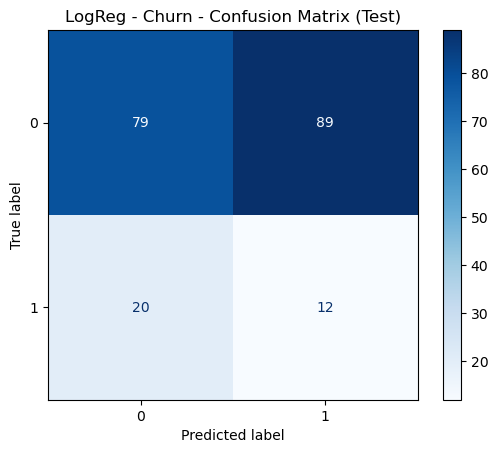

In [42]:
# Evaluating churn model

evaluate_model(logreg_churn, Xtrain_churn, ytrain_churn, Xtest_churn, ytest_churn, name="LogReg - Churn")

### Insights:
* We first tested a Logistic Regression model to predict customer default and churn. While this gave us a starting baseline, the results show that the model struggles to clearly separate risky customers from safe ones.  
* For default prediction, the model was able to catch some defaulters (recall ~53%), but it also flagged too many safe customers by mistake (precision only ~20%).  
* For churn prediction, the performance was even weaker, with the model close to random guessing.  
* The main reason is that the data is imbalanced (only 14–16% of customers default or churn), and Logistic Regression, being a simple linear model, is not powerful enough to capture the complex patterns in spending, delinquency, and engagement behavior.

**Recommendation**  
* Logistic Regression served as a good baseline, but to improve prediction accuracy we will: 
    1. Use advanced models like Random Forest or XGBoost that can capture more complex relationships.  
    2. Balance the data better so the model learns from both risky and safe customers.
    3. Fine-tune thresholds to reduce false alarms and improve actionable insights.
* This way, the bank will have a more reliable early-warning system to identify which customers are likely to default or churn, enabling proactive action.

In [43]:
# Proceeding with Random forest
# We will first try with class_weight=balanced since there is class imbalance and tree based models are good in dealing with class imbalances
# If the results are still weak then we will try with SMOTE technique

# Randorm forest for default_flag

rf_default = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ))
])

# Randorm forest for churn_flag

rf_churn = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ))
])


In [44]:
# fit the model

rf_default.fit(Xtrain_default, ytrain_default)
rf_churn.fit(Xtrain_churn, ytrain_churn)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['LOAN_TYPE', 'GENDER',
                                                   'EMPLOYMENT_STATUS', 'CITY',
                                                   'RESPONSE_TO_OFFERS']),
                                                 ('num', StandardScaler(),
                                                  ['AGE', 'CREDIT_SCORE',
                                                   'CREDIT_UTILIZATION',
                                                   'LOAN_AMOUNT',
                                                   'FD_INVESTMENT', 'INSURANCE',
                                                   'CREDIT_CARD',
                                                   'NET_BANKING_USAGE',
                                                   'MOBILE_APP_USAGE',
                                                   'COMPLAINTS_RAISED',
                                                   'AVG_MONTHLY_INCOME',
                                                   'EXPENSE_TO_INCOME_RATIO',
                                                   'TOTAL_CARD_SPEND',
                                                   'OVER_BUDGET_RATIO',
                                                   'DELINQUENCY_COUNT_12M',
                                                   'INCOME_BRACKET_NUM',
                                                   'LOAN_HISTORY_NUM'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, n_jobs=-1,
                                        random_state=42))])


=== RF - Default Evaluation ===
Train AUC: 1.0
Test  AUC: 0.654
Test F1 Score: 0.0
Test Precision: 0.0
Test Recall: 0.0


C:\Users\Win10\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


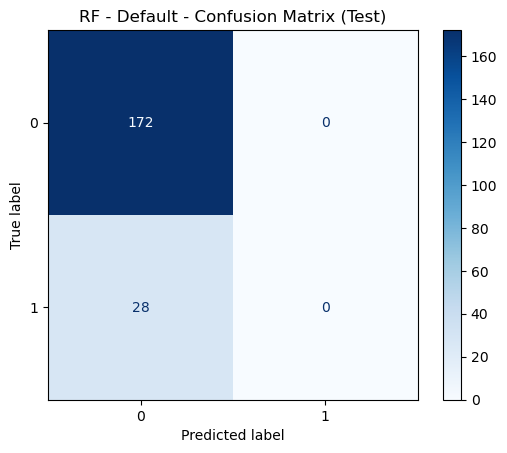


=== RF - Churn Evaluation ===
Train AUC: 1.0
Test  AUC: 0.507
Test F1 Score: 0.0
Test Precision: 0.0
Test Recall: 0.0


C:\Users\Win10\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


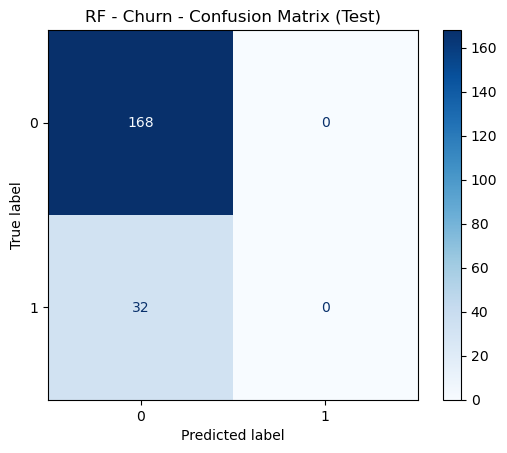

In [46]:
# evaluating the model

evaluate_model(rf_default, Xtrain_default, ytrain_default, Xtest_default, ytest_default, name='RF - Default')
evaluate_model(rf_churn, Xtrain_churn, ytrain_churn, Xtest_churn, ytest_churn, name='RF - Churn')

### Insights:
* Train AUC = 1.0 which means the Random Forest is completely overfitting the training data.
* Test AUC = 0.654 (Default) & 0.507 (Churn) which means no generalization and basically random for churn.
* F1/Precision/Recall = 0 - The model is predicting all customers as majority class(0).
* As we can see, the class imbalance has not been handled strongly enough here.
* We will try with threshold tuning or SMOTE oversampling.

In [47]:
# Make a validation split
# Rebuilding the RF pipeline 
def make_rf_pipeline():
    return Pipeline(steps=[
        ("prep", preprocessor),
        ("clf", RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            min_samples_leaf=5,      
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        ))
    ])

In [48]:
# Default (validation split + refit for tuning)

Xtr_d, Xval_d, ytr_d, yval_d = train_test_split(
    Xtrain_default, ytrain_default, test_size=0.25, stratify=ytrain_default, random_state=42
)

rf_default_cv = make_rf_pipeline()
rf_default_cv.fit(Xtr_d, ytr_d)

val_proba_d = rf_default_cv.predict_proba(Xval_d)[:, 1]

In [49]:
# Churn Flag (validation split + refit for tuning)

Xtr_c, Xval_c, ytr_c, yval_c = train_test_split(
    Xtrain_churn, ytrain_churn, test_size=0.25, stratify=ytrain_churn, random_state=42
)

rf_churn_cv = make_rf_pipeline()
rf_churn_cv.fit(Xtr_c, ytr_c)

val_proba_c = rf_churn_cv.predict_proba(Xval_c)[:, 1]

In [50]:
# We will compute Precision, Recall and F1 across many thresholds
# Pick a threshold that maximizes F1 or satisfies a recall target

def tune_threshold(y_true, y_proba, recall_target=None):
    thrs = np.linspace(0.05, 0.95, 19)
    rows = []
    for t in thrs:
        y_pred = (y_proba >= t).astype(int)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)
        f1   = f1_score(y_true, y_pred, zero_division=0)
        pos_rate = y_pred.mean()
        rows.append([t, prec, rec, f1, pos_rate])
    out = pd.DataFrame(rows, columns=["threshold","precision","recall","f1","predicted_positive_rate"])

    if recall_target is not None:
        # best precision subject to recall >= target; if none meet, take the max recall
        candidates = out[out["recall"] >= recall_target]
        if len(candidates) > 0:
            best = candidates.sort_values(["precision","f1"], ascending=False).iloc[0]
        else:
            best = out.sort_values("recall", ascending=False).iloc[0]
    else:
        best = out.sort_values("f1", ascending=False).iloc[0]

    return out, best

# DEFAULT: tune on validation
grid_d, best_d = tune_threshold(yval_d, val_proba_d, recall_target=None)  
print("Default best (by F1):\n", best_d)

# CHURN: tune on validation
grid_c, best_c = tune_threshold(yval_c, val_proba_c, recall_target=None)
print("Churn best (by F1):\n", best_c)

Default best (by F1):
 threshold                  0.250000
precision                  0.224719
recall                     0.689655
f1                         0.338983
predicted_positive_rate    0.445000
Name: 4, dtype: float64
Churn best (by F1):
 threshold                  0.250000
precision                  0.178571
recall                     0.781250
f1                         0.290698
predicted_positive_rate    0.700000
Name: 4, dtype: float64


In [53]:
# Refitting the model on full train set & evaluate on test at tuned threshold

def eval_with_threshold(model, Xtr, ytr, Xte, yte, thr, name="Model"):
    model.fit(Xtr, ytr)
    proba_tr = model.predict_proba(Xtr)[:,1]
    proba_te = model.predict_proba(Xte)[:,1]

    ypred_te = (proba_te >= thr).astype(int)

    print(f"\n=== {name} @ threshold={thr:.2f} ===")
    print("Train AUC:", roc_auc_score(ytr, proba_tr).round(3))
    print("Test  AUC:", roc_auc_score(yte, proba_te).round(3))

    print("Test Precision:", precision_score(yte, ypred_te, zero_division=0).round(3))
    print("Test Recall   :", recall_score(yte, ypred_te, zero_division=0).round(3))
    print("Test F1       :", f1_score(yte, ypred_te, zero_division=0).round(3))

    cm = confusion_matrix(yte, ypred_te)
    tn, fp, fn, tp = cm.ravel()
    print("Confusion Matrix:\n", cm)
    print(f"TP: {tp}  TN: {tn}  FP: {fp}  FN: {fn}")
    print("\nClassification Report:\n", classification_report(yte, ypred_te, zero_division=0))

# DEFAULT final eval
rf_default_final = make_rf_pipeline()
eval_with_threshold(rf_default_final, Xtrain_default, ytrain_default,
                    Xtest_default,  ytest_default, thr=float(best_d["threshold"]),
                    name="RF - Default")

# CHURN final eval
rf_churn_final = make_rf_pipeline()
eval_with_threshold(rf_churn_final, Xtrain_churn, ytrain_churn,
                    Xtest_churn,  ytest_churn, thr=float(best_c["threshold"]),
                    name="RF - Churn")


=== RF - Default @ threshold=0.25 ===
Train AUC: 0.999
Test  AUC: 0.627
Test Precision: 0.198
Test Recall   : 0.75
Test F1       : 0.313
Confusion Matrix:
 [[87 85]
 [ 7 21]]
TP: 21  TN: 87  FP: 85  FN: 7

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.51      0.65       172
           1       0.20      0.75      0.31        28

    accuracy                           0.54       200
   macro avg       0.56      0.63      0.48       200
weighted avg       0.82      0.54      0.61       200


=== RF - Churn @ threshold=0.25 ===
Train AUC: 1.0
Test  AUC: 0.491
Test Precision: 0.147
Test Recall   : 0.719
Test F1       : 0.245
Confusion Matrix:
 [[ 35 133]
 [  9  23]]
TP: 23  TN: 35  FP: 133  FN: 9

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.21      0.33       168
           1       0.15      0.72      0.24        32

    accuracy                           0.29  

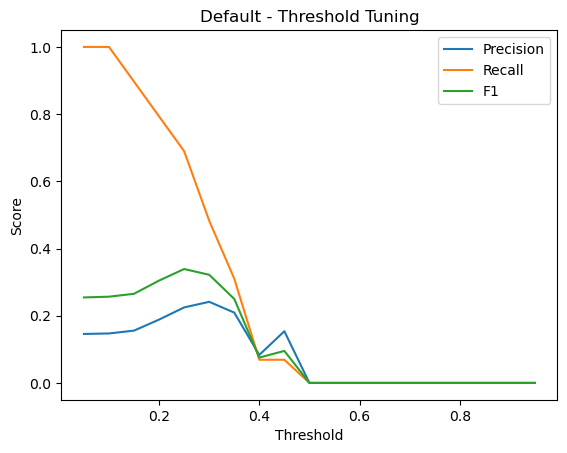

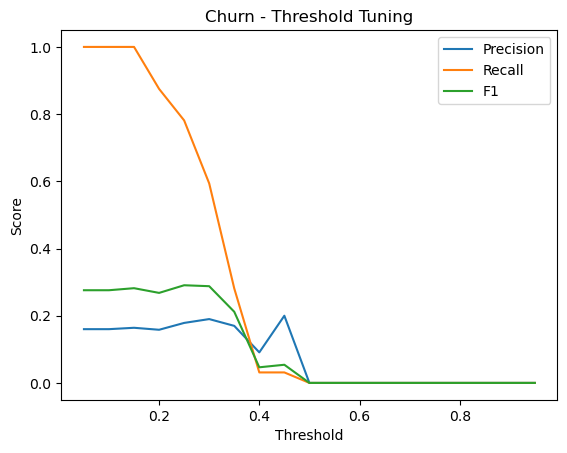

In [54]:
def plot_threshold_curve(grid_df, title="Threshold Tuning"):
    plot.figure()
    plot.plot(grid_df["threshold"], grid_df["precision"], label="Precision")
    plot.plot(grid_df["threshold"], grid_df["recall"], label="Recall")
    plot.plot(grid_df["threshold"], grid_df["f1"], label="F1")
    plot.xlabel("Threshold"); plot.ylabel("Score")
    plot.title(title)
    plot.legend(); plot.show()

plot_threshold_curve(grid_d, "Default - Threshold Tuning")
plot_threshold_curve(grid_c, "Churn - Threshold Tuning")

### Insights:
* **Default Model**
* Recall=0.75 - Able to catch 75% of defaulters
* Precision=0.2 - Only 1 in 5 flagged customers actually defaults
* Overall Accuracy=54% - Misleading because its skewed by imbalance
* It can be useful as a risk detector but has too many false positives
* **Churn Model**
* Recall=0.72 - Able to catch most churners
* Precision=0.15 - Very weak reliability which means many safe customers misclassified as churn risks
* In this approach, we tested Random Forest Models with adjusted probability thresholds to better detect risky customers.
* For defaults, the model can successfully identify 75% of customers who are likely to default, but it does so with many false positives (precision only 20%). This makes it more useful as an early-warning tool rather than a precise decision-maker.
* For churn, the model also captures ~72% of churners, but the precision is even lower (15%). This means the model is not yet reliable enough for targeting retention offers.
* Since, Random Forest is already overfitting, we want a model banks/finance teams can typically trust for risk+churn prediction and class imbalance is better handled with XGBoost. So, we will move to XGBoost with class weighting.

In [56]:
# Compute scale_positive_weight
# This is a key parameter which tells XGBoost how to balance classes

# For Default
negative_default = (ytrain_default == 0).sum()
positive_default = (ytrain_default == 1).sum()
scale_positive_weight_default = negative_default / positive_default
print("Default scale_positive_weight:", scale_positive_weight_default)

# For Churn
negative_churn = (ytrain_churn == 0).sum()
positive_churn = (ytrain_churn == 1).sum()
scale_positive_weight_churn = negative_churn / positive_churn
print("Churn scale_positive_weight:", scale_positive_weight_churn)

Default scale_positive_weight: 6.017543859649122
Churn scale_positive_weight: 5.153846153846154


In [57]:
# XGBoost for Default
xgb_default = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        scale_pos_weight=scale_positive_weight_default,
        eval_metric="logloss",
        use_label_encoder=False
    ))
])

# XGBoost for Churn
xgb_churn = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        scale_pos_weight=scale_positive_weight_churn,
        eval_metric="logloss",
        use_label_encoder=False
    ))
])

In [58]:
# Fitting the model

xgb_default.fit(Xtrain_default, ytrain_default)
xgb_churn.fit(Xtrain_churn, ytrain_churn)

C:\Users\Win10\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:21:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Win10\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:21:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['LOAN_TYPE', 'GENDER',
                                                   'EMPLOYMENT_STATUS', 'CITY',
                                                   'RESPONSE_TO_OFFERS']),
                                                 ('num', StandardScaler(),
                                                  ['AGE', 'CREDIT_SCORE',
                                                   'CREDIT_UTILIZATION',
                                                   'LOAN_AMOUNT',
                                                   'FD_INVESTMENT', 'INSURANCE',
                                                   'CREDIT_CARD',
                                                   'NET_BANKING_USAGE',
                                                   'MOBILE_APP_U...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])


=== XGB - Default Evaluation ===
Train AUC: 1.0
Test  AUC: 0.571
Test F1 Score: 0.098
Test Precision: 0.154
Test Recall: 0.071


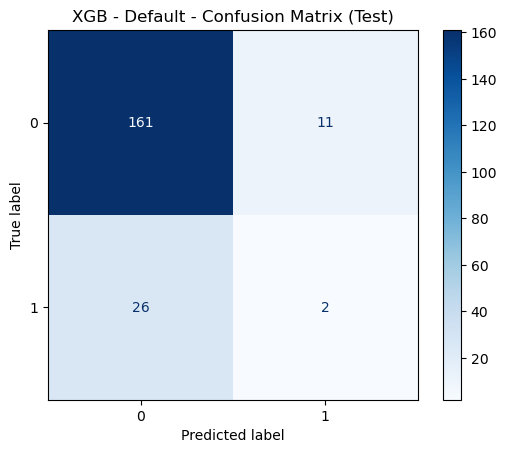


=== XGB - Churn Evaluation ===
Train AUC: 1.0
Test  AUC: 0.538
Test F1 Score: 0.125
Test Precision: 0.188
Test Recall: 0.094


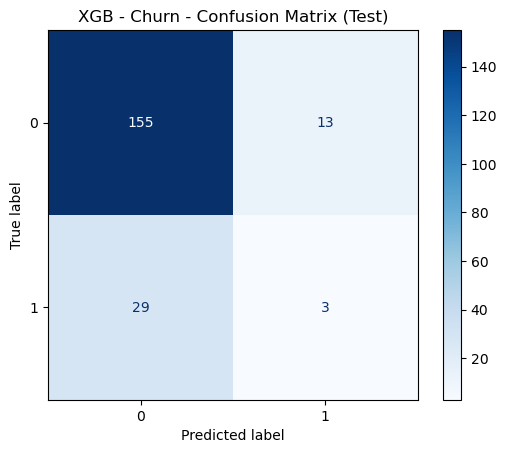

In [59]:
# Evaluating the model

evaluate_model(xgb_default, Xtrain_default, ytrain_default, Xtest_default, ytest_default, name="XGB - Default")
evaluate_model(xgb_churn, Xtrain_churn, ytrain_churn, Xtest_churn, ytest_churn, name="XGB - Churn")

### Insights:
* Our experiments show that simple models (Logistic Regression) underfit, while complex ones (Random Forest, XGBoost) overfit and default to majority class predictions. This is mainly due to class imbalance and limited positive samples. To improve, we will rebalance the dataset using synthetic oversampling (SMOTE) and fine-tune advanced models with stronger regularization. This will help us catch more risky customers without overwhelming false alarms.

In [61]:
# Building SMOTE + Logistic Regression Pipeline

# SMOTE parameters: k_neighbors=5 (default), can adjust if too few positives
smote = SMOTE(random_state=42)

# Logistic Regression with SMOTE for Default
smote_logreg_default = ImbPipeline(steps=[
    ("prep", preprocessor),      # encoding + scaling
    ("smote", smote),            # oversample minority
    ("clf", LogisticRegression(
        max_iter=2000,
        solver="lbfgs",
        class_weight=None        # turn off since SMOTE balances data
    ))
])

# Logistic Regression with SMOTE for Churn
smote_logreg_churn = ImbPipeline(steps=[
    ("prep", preprocessor),
    ("smote", smote),
    ("clf", LogisticRegression(
        max_iter=2000,
        solver="lbfgs",
        class_weight=None
    ))
])

In [62]:
# Fit the models
smote_logreg_default.fit(Xtrain_default, ytrain_default)
smote_logreg_churn.fit(Xtrain_churn, ytrain_churn)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['LOAN_TYPE', 'GENDER',
                                                   'EMPLOYMENT_STATUS', 'CITY',
                                                   'RESPONSE_TO_OFFERS']),
                                                 ('num', StandardScaler(),
                                                  ['AGE', 'CREDIT_SCORE',
                                                   'CREDIT_UTILIZATION',
                                                   'LOAN_AMOUNT',
                                                   'FD_INVESTMENT', 'INSURANCE',
                                                   'CREDIT_CARD',
                                                   'NET_BANKING_USAGE',
                                                   'MOBILE_APP_USAGE',
                                                   'COMPLAINTS_RAISED',
                                                   'AVG_MONTHLY_INCOME',
                                                   'EXPENSE_TO_INCOME_RATIO',
                                                   'TOTAL_CARD_SPEND',
                                                   'OVER_BUDGET_RATIO',
                                                   'DELINQUENCY_COUNT_12M',
                                                   'INCOME_BRACKET_NUM',
                                                   'LOAN_HISTORY_NUM'])])),
                ('smote', SMOTE(random_state=42)),
                ('clf', LogisticRegression(max_iter=2000))])


=== SMOTE + LogReg - Default Evaluation ===
Train AUC: 0.746
Test  AUC: 0.581
Test F1 Score: 0.247
Test Precision: 0.174
Test Recall: 0.429


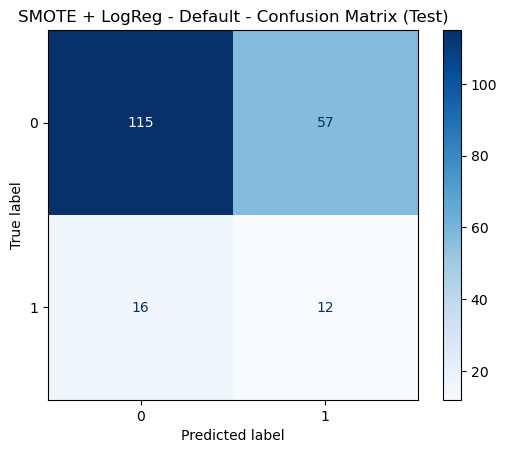


=== SMOTE + LogReg - Churn Evaluation ===
Train AUC: 0.62
Test  AUC: 0.424
Test F1 Score: 0.185
Test Precision: 0.126
Test Recall: 0.344


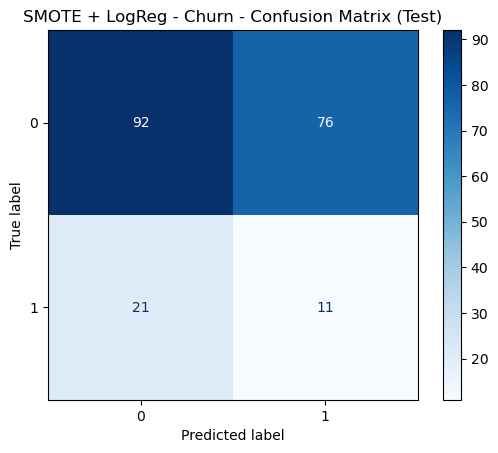

In [63]:
# Evaluating the models

evaluate_model(smote_logreg_default, Xtrain_default, ytrain_default, Xtest_default, ytest_default, name="SMOTE + LogReg - Default")
evaluate_model(smote_logreg_churn, Xtrain_churn, ytrain_churn, Xtest_churn, ytest_churn, name="SMOTE + LogReg - Churn")

### Insights:
**Default Model**
* Test Recall = 43% - We are able to catch more defaulters than plain Logistic Regression
* Test Precision = 17% - Still low, which means most flagged customers don't actually default
* We are able to identify more risky customers but the false alarm rate remains high
**Churn Model**
* Test Recall = 34% - Better than 9% with plain XGBoost, but still not strong
* Precision = 12% - Very weak, retention target would waste resources
* AUC = 0.42 - Model sligtly performs better than random guessing
* Churn patterns are harder to capture with the current features
* We tested SMOTE (synthetic oversampling) with Logistic Regression to address class imbalance. This helped the models capture more risky customers (higher recall), but overall predictive power remains weak:
* 1. For defaults, recall improved to 43%, meaning we catch more defaulters, but with many false positives.
* 2. For churn, the model remains unreliable, with recall at 34% and very low precision.
* This shows that while rebalancing helped a bit, the dataset still lacks strong predictive signals for churn and default when using a linear model.

In [64]:
# Building SMOTE + XGBoost Pipeline

smote = SMOTE(random_state=42)

# SMOTE + XGBoost for Default
smote_xgb_default = ImbPipeline(steps=[
    ("prep", preprocessor),
    ("smote", smote),
    ("clf", XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=4,            # shallower trees to prevent overfit
        min_child_weight=10,    # require more samples per leaf
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=1,                # penalize weak splits
        random_state=42,
        eval_metric="logloss",
        use_label_encoder=False
    ))
])

# SMOTE + XGBoost for Churn
smote_xgb_churn = ImbPipeline(steps=[
    ("prep", preprocessor),
    ("smote", smote),
    ("clf", XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=4,
        min_child_weight=10,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=1,
        random_state=42,
        eval_metric="logloss",
        use_label_encoder=False
    ))
])

In [65]:
# Fitting the model

smote_xgb_default.fit(Xtrain_default, ytrain_default)
smote_xgb_churn.fit(Xtrain_churn, ytrain_churn)

C:\Users\Win10\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:48:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\Win10\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:48:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['LOAN_TYPE', 'GENDER',
                                                   'EMPLOYMENT_STATUS', 'CITY',
                                                   'RESPONSE_TO_OFFERS']),
                                                 ('num', StandardScaler(),
                                                  ['AGE', 'CREDIT_SCORE',
                                                   'CREDIT_UTILIZATION',
                                                   'LOAN_AMOUNT',
                                                   'FD_INVESTMENT', 'INSURANCE',
                                                   'CREDIT_CARD',
                                                   'NET_BANKING_USAGE',
                                                   'MOBILE_APP_U...
                               feature_types=None, feature_weights=None,
                               gamma=1, grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=4, max_leaves=None,
                               min_child_weight=10, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])


=== SMOTE + XGB - Default Evaluation ===
Train AUC: 0.961
Test  AUC: 0.612
Test F1 Score: 0.194
Test Precision: 0.159
Test Recall: 0.25


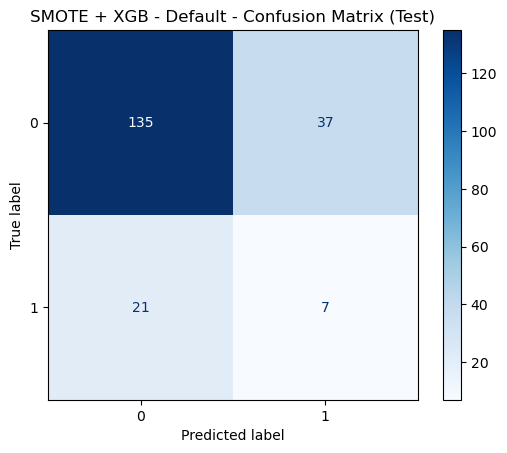


=== SMOTE + XGB - Churn Evaluation ===
Train AUC: 0.988
Test  AUC: 0.447
Test F1 Score: 0.053
Test Precision: 0.167
Test Recall: 0.031


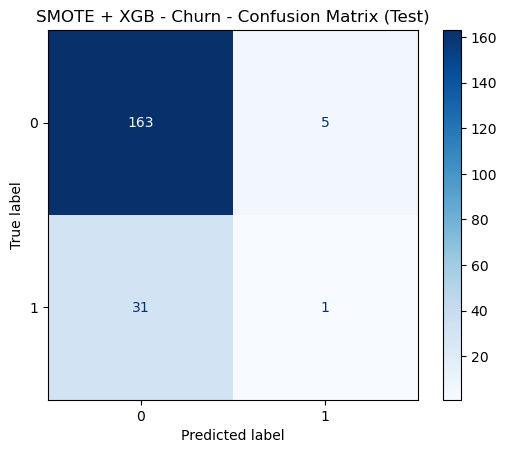

In [66]:
# Evaluating the model

evaluate_model(smote_xgb_default, Xtrain_default, ytrain_default, Xtest_default, ytest_default, name="SMOTE + XGB - Default")
evaluate_model(smote_xgb_churn, Xtrain_churn, ytrain_churn, Xtest_churn, ytest_churn, name="SMOTE + XGB - Churn")

### Insights:
**Default Model**
* Test AUC: 0.61 - only slightly better than random
* Recall: 25% - only 1 in 4 defaulters are caught
* Precision: 15% - still very high false alarm rate
* This approach misses most defaulters and still misclassifies many safe customers.
**Churn Model**
* Test AUC: 0.44 - worse than random guessing
* Recall: 3% - model is essentially not learning churn patterns
* Precision: 16% - meaningless given the low recall
* Clearly failed to capture churn signals
* We tested SMOTE with XGBoost, which is a powerful method often used in financial services. While the models performed very strongly on training data, they did not generalize well to unseen customers:
1. For defaults, the model caught only 25% of defaulters and misclassified many safe customers, with an overall AUC of just 0.61.
2. For churn, the model failed almost completely, with performance worse than random guessing.
* This shows that simply rebalancing the data and using advanced models is not enough. The underlying issue is that our current dataset lacks strong predictive signals for churn and defaults.

### Conclusion:
* In this project, we explored 1,000 customer profiles to identify risks of default and churn.
* The models showed that default prediction has potential as an early-warning tool with recall up to 75%, but precision remains low. This means banks can use it to monitor at-risk customers, but final decisions should involve additional checks.
* For churn, models did not generalize well with the current features. This highlights the need for more behavioral and temporal data to understand customer loyalty.
* Recommendations:
1. Use current default models for monitoring.
2. Invest in collecting richer features for churn.
3. Enhance customer service processes to reduce complaints.
4. Expand analytics with trend-based features for more reliable predictions.